In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from glob import glob

import xarray as xr
from netCDF4 import Dataset
import requests

In [292]:
data = pd.read_excel('DataCollection_m.xlsx',sheet_name='Samples Data')
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

numeric_columns = data.columns.drop(['Timestamp','Sample']) 
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

data = data[(data['Sample'].str.endswith('S') | data['Sample'].str.endswith('B'))]

data.columns

Index(['Sample', 'Station', 'Timestamp', 'Latitude', 'Longitude', 'Depth',
       'Seafloor depth', 'Salinity', 'Temperature', 'Fluorescence', 'NPOC',
       'TN'],
      dtype='object')

In [293]:
len(data['Station'].unique())

17

In [294]:
aml = pd.read_excel('DataCollection_m.xlsx',sheet_name='AML filtered')
aml['Timestamp'] = pd.to_datetime(aml['Timestamp'])

numeric_columns = aml.columns.drop(['Timestamp']) 
aml[numeric_columns] = aml[numeric_columns].apply(pd.to_numeric, errors='coerce')

aml = aml[(aml['Depth'] > 1) & (aml['Depth'] < aml['Depth'].max() - 1)]

aml.columns

Index(['Station', 'Timestamp', 'Latitude', 'Longitude', 'Vbat', 'Cond',
       'TempCT', 'Pressure', 'DO', 'TempDO', 'DOM', 'Chloro-blue', 'Turbidity',
       'analog', 'Salinity', 'Density', 'CalcSV', 'Depth'],
      dtype='object')

In [295]:
rbr = pd.read_excel('DataCollection_m.xlsx',sheet_name='RBR filtered')
rbr['Timestamp'] = pd.to_datetime(aml['Timestamp'])

numeric_columns = rbr.columns.drop(['Timestamp']) 
rbr[numeric_columns] = rbr[numeric_columns].apply(pd.to_numeric, errors='coerce')

rbr = rbr[(rbr['    depth(m)'] > 1) & (rbr['    depth(m)'] < rbr['    depth(m)'].max() - 1)]

rbr.columns

Index(['Timestamp', 'Station', 'Latitude', 'Longitude', '    depth(m)',
       '    conductivity(mS/cm)', '    temperature(°C)', '    pressure(dbar)',
       '    temperature1(°C)', '    dissolved_o2_concentration(µmol/L)',
       '    chlorophyll-a(ug/l)', '    fdom(ppb)', '    turbidity(FTU)',
       '    voltage(V)', '    voltage1(V)', '    voltage2(V)',
       '    voltage3(V)', '    sea_pressure(dbar)', '    salinity(PSU)',
       '    speed_of_sound(m/s)', '    specific_conductivity(µS/cm)',
       '    dissolved_o2_saturation(%)'],
      dtype='object')

In [296]:
aml['Depth'].max(), rbr['    depth(m)'].max(), data['Seafloor depth'].max()

(21.29805, 21.17963409, 28.86)

## DOM.S diagrams

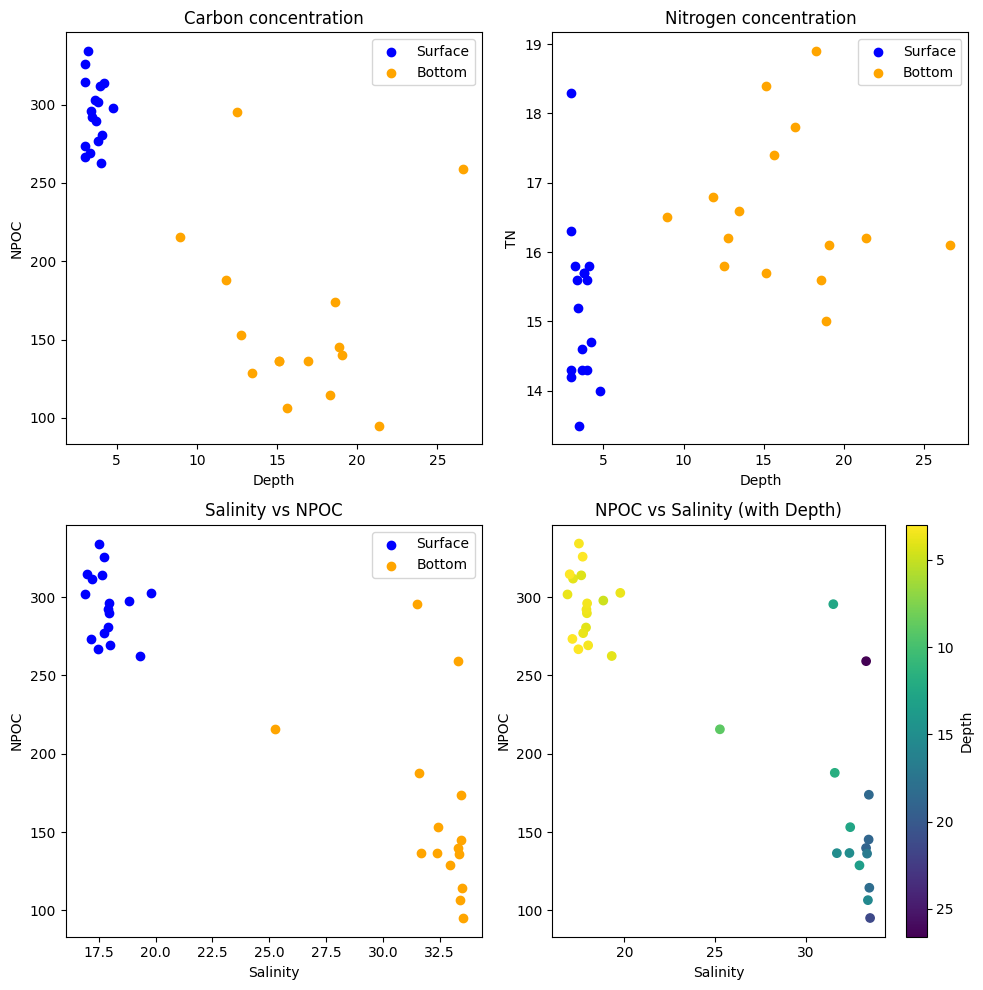

In [263]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
axs[0].scatter(
    data[(data['Sample'].str.endswith('S'))]['Depth'],
    data[(data['Sample'].str.endswith('S'))]['NPOC'],
    color='blue',
    label='Surface'
)

axs[0].scatter(
    data[(data['Sample'].str.endswith('B'))]['Depth'],
    data[(data['Sample'].str.endswith('B'))]['NPOC'],
    color='orange',
    label='Bottom'
)

axs[0].set_xlabel("Depth")
axs[0].set_ylabel("NPOC")
axs[0].set_title("Carbon concentration")
axs[0].legend()


axs[2].scatter(
    data[(data['Sample'].str.endswith('S'))]['Salinity'],
    data[(data['Sample'].str.endswith('S'))]['NPOC'],
    color='blue',
    label='Surface'
)

axs[2].scatter(
    data[(data['Sample'].str.endswith('B'))]['Salinity'],
    data[(data['Sample'].str.endswith('B'))]['NPOC'],
    color='orange',
    label='Bottom'
)

axs[2].set_xlabel("Salinity")
axs[2].set_ylabel("NPOC")
axs[2].set_title("Salinity vs NPOC")
axs[2].legend()


axs[1].scatter(
    data[(data['Sample'].str.endswith('S'))]['Depth'],
    data[(data['Sample'].str.endswith('S'))]['TN'],
    color='blue',
    label='Surface'
)

axs[1].scatter(
    data[(data['Sample'].str.endswith('B'))]['Depth'],
    data[(data['Sample'].str.endswith('B'))]['TN'],
    color='orange',
    label='Bottom'
)

axs[1].set_xlabel("Depth")
axs[1].set_ylabel("TN")
axs[1].set_title("Nitrogen concentration")
axs[1].legend()


scatter = axs[3].scatter(
    data['Salinity'], 
    data['NPOC'], 
    c=data['Depth'], 
    cmap='viridis_r'
)

# Add color bar
cbar = plt.colorbar(scatter, ax=axs[3])
cbar.set_label('Depth')
cbar.ax.invert_yaxis()

# Set labels and title for the subplot
axs[3].set_xlabel("Salinity")
axs[3].set_ylabel("NPOC")
axs[3].set_title("NPOC vs Salinity (with Depth)")
                    

plt.tight_layout()
plt.show()

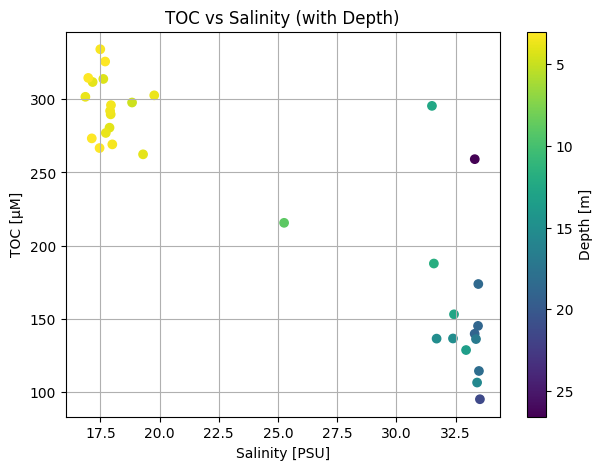

In [423]:
fig, ax = plt.subplots(figsize=(7, 5))

scatter = ax.scatter(
    data['Salinity'], 
    data['NPOC'], 
    c=data['Depth'], 
    cmap='viridis_r')

# Add color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Depth [m]')
cbar.ax.invert_yaxis()  # Invert y-axis of the color bar if needed

# Set labels and title for the subplot
ax.set_xlabel("Salinity [PSU]")
ax.set_ylabel("TOC [µM]")
ax.set_title("TOC vs Salinity (with Depth)")
ax.grid()

# Show the plot
plt.show()

## AML vs RBR correlation (in terms of DOM measurement)

In [264]:

## ALL DATA
# For each station
# Get max depth
# Make a regular grid for every 0.1m from 0m up to that depth
# Interpolate AML for that grid
# Interpolate RBR for that grid

dom_measure_df = pd.DataFrame()
dfs = []

for i,row in data.iterrows():

    station = row['Station']
    aml_station_data = aml[aml['Station'] == station]
    rbr_station_data = rbr[rbr['Station'] == station]
    
    max_depth = max(aml_station_data['Depth'].max(), rbr_station_data['    depth(m)'].max())
    
    grid = np.arange(0, max_depth + 0.05, 0.05)
    measurement_df = pd.DataFrame(grid, columns=['Depth'])
    
    measurement_df['AML DOM'] = np.interp(grid, aml_station_data['Depth'], aml_station_data['DOM'])
    measurement_df['RBR DOM'] = np.interp(grid, rbr_station_data['    depth(m)'], rbr_station_data['    fdom(ppb)'])
    measurement_df['Station'] = station
    dfs.append(measurement_df)

dom_measure_df = pd.concat(dfs, ignore_index=True)
dom_measure_df = dom_measure_df[['Station','Depth','AML DOM', 'RBR DOM']]
dom_measure_df



,Station,Depth,AML DOM,RBR DOM
0,308,0.00,0.081357,0.089228
1,308,0.05,0.081357,0.089228
2,308,0.10,0.081357,0.089228
3,308,0.15,0.081357,0.089228
4,308,0.20,0.081357,0.089228
...,...,...,...,...
11717,337,18.30,0.057013,0.069329
11718,337,18.35,0.057246,0.069862
11719,337,18.40,0.058156,0.071016
11720,337,18.45,0.056356,0.071706


In [265]:
dom_corr = dom_measure_df['AML DOM'].corr(dom_measure_df['RBR DOM'])
dom_corr = dom_measure_df['RBR DOM'].corr(dom_measure_df['AML DOM'])

dom_corr

0.5438232811716532

In [266]:
## WITHOUT 323

# For each station
# Get max depth
# Make a regular grid for every 0.1m from 0m up to that depth
# Interpolate AML for that grid
# Interpolate RBR for that grid

dom_measure_df2 = pd.DataFrame()
dfs = []
aml2 = aml[(aml['Station']!=323)]
rbr2 = rbr[(rbr['Station']!=323)]
data2 = data[(data['Station']!=323)]

for i,row in data2.iterrows():
    
    station = row['Station']
    aml_station_data = aml2[aml2['Station'] == station]
    rbr_station_data = rbr2[rbr2['Station'] == station]
    
    max_depth = max(aml_station_data['Depth'].max(), rbr_station_data['    depth(m)'].max())
    
    grid = np.arange(0, max_depth + 0.05, 0.05)
    measurement_df = pd.DataFrame(grid, columns=['Depth'])
    
    measurement_df['AML DOM'] = np.interp(grid, aml_station_data['Depth'], aml_station_data['DOM'])
    measurement_df['RBR DOM'] = np.interp(grid, rbr_station_data['    depth(m)'], rbr_station_data['    fdom(ppb)'])
    measurement_df['Station'] = station
    dfs.append(measurement_df)

dom_measure_df2 = pd.concat(dfs, ignore_index=True)
dom_measure_df2 = dom_measure_df2[['Station','Depth','AML DOM', 'RBR DOM']]
dom_measure_df2

308
308
309
309
310
310
311
311
312
312
313
313
316
316
318
318
319
319
320
320
321
321
322
322
329
329
332
332
335
335
337
337


,Station,Depth,AML DOM,RBR DOM
0,308,0.00,0.081357,0.089228
1,308,0.05,0.081357,0.089228
2,308,0.10,0.081357,0.089228
3,308,0.15,0.081357,0.089228
4,308,0.20,0.081357,0.089228
...,...,...,...,...
11209,337,18.30,0.057013,0.069329
11210,337,18.35,0.057246,0.069862
11211,337,18.40,0.058156,0.071016
11212,337,18.45,0.056356,0.071706


In [267]:
dom_corr2 = dom_measure_df2['AML DOM'].corr(dom_measure_df2['RBR DOM'])
dom_corr2 = dom_measure_df2['RBR DOM'].corr(dom_measure_df2['AML DOM'])

dom_corr2

0.9501870009733875

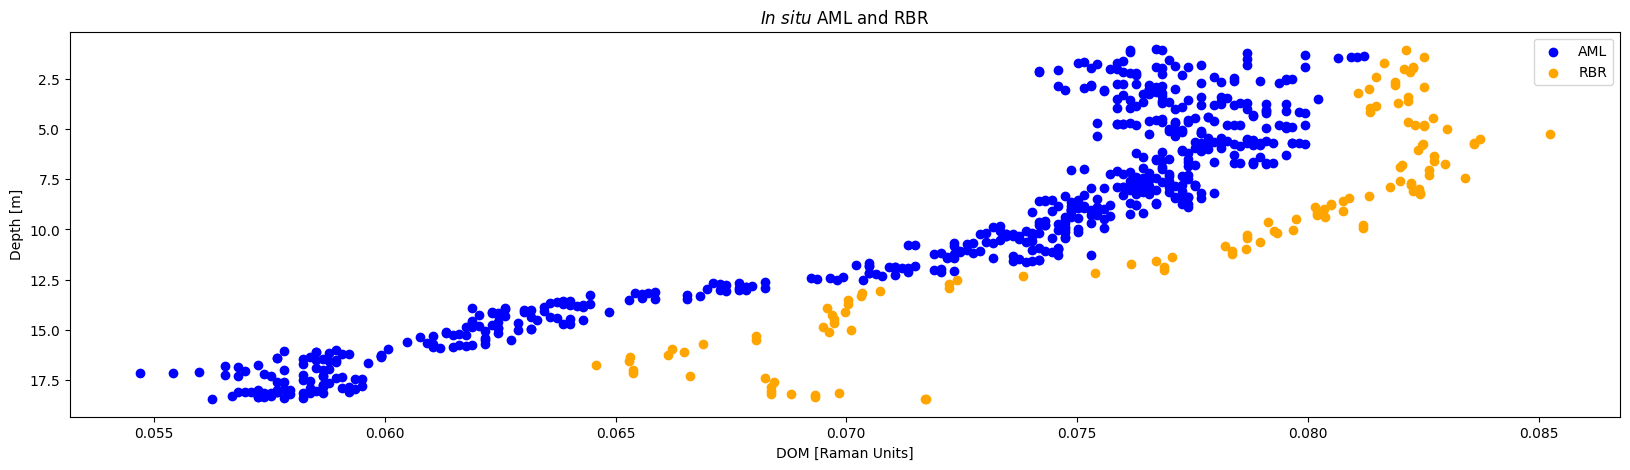

In [522]:

fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.scatter(
    aml2['DOM'],
    aml2['Depth'],
    color='blue',
    label='AML'
)

axs.scatter(
    rbr2[(rbr2['    fdom(ppb)'] < 20)]['    fdom(ppb)'],
    rbr2[(rbr2['    fdom(ppb)'] < 20)]['    depth(m)'],
    color='orange',
    label='RBR'
)

axs.set_xlabel("DOM [Raman Units]")
axs.set_ylabel("Depth [m]")
axs.set_title(r'$\it{In\ situ}$'+' AML and RBR')
axs.invert_yaxis()
axs.legend()

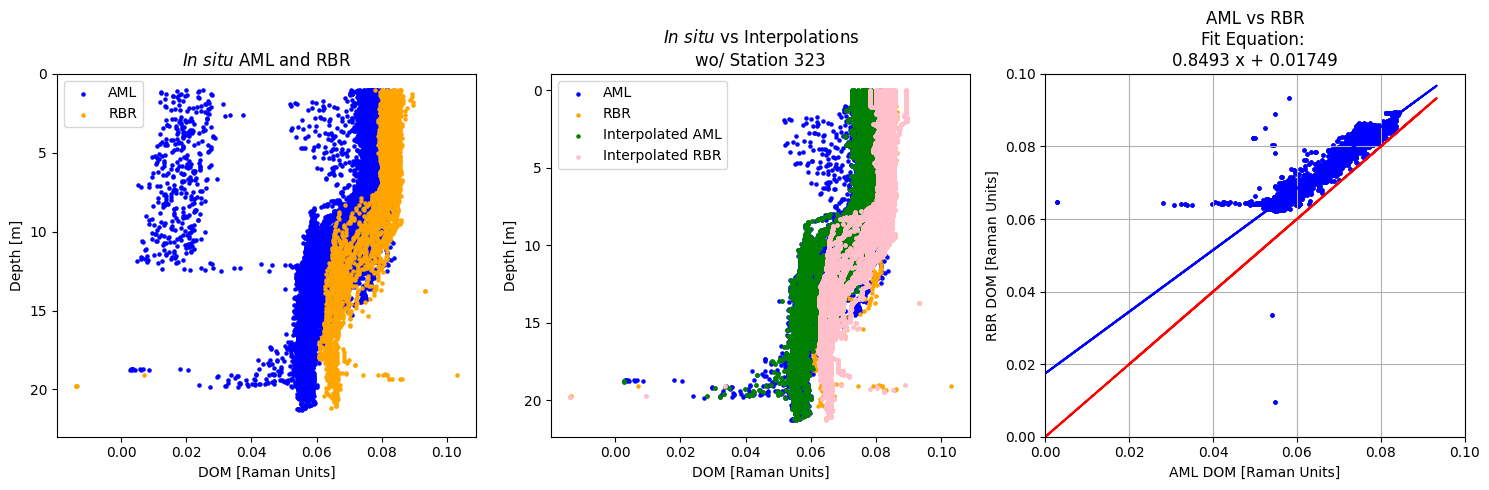

In [532]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
axs[0].scatter(
    aml['DOM'],
    aml['Depth'],
    color='blue',
    label='AML',
    s=5
)

axs[0].scatter(
    rbr[(rbr['    fdom(ppb)'] < 20)]['    fdom(ppb)'],
    rbr[(rbr['    fdom(ppb)'] < 20)]['    depth(m)'],
    color='orange',
    label='RBR',
    s=5
)

axs[0].set_xlabel("DOM [Raman Units]")
axs[0].set_ylabel("Depth [m]")
axs[0].set_title(r'$\it{In\ situ}$'+' AML and RBR')
axs[0].set_ylim([0,23])
axs[0].invert_yaxis()
axs[0].legend()



# axs[1].scatter(
#     aml['DOM'],
#     aml['Depth'],
#     color='blue',
#     label='AML',
#     s=5
# )

# axs[1].scatter(
#     rbr['    fdom(ppb)'],
#     rbr['    depth(m)'],
#     color='orange',
#     label='RBR',
#     s=5
# )

# axs[1].scatter(
#     dom_measure_df['AML DOM'],
#     dom_measure_df['Depth'],
#     color='green',
#     label='Interpolated AML'
# )

# axs[1].scatter(
#     dom_measure_df['RBR DOM'],
#     dom_measure_df['Depth'],
#     color='pink',
#     label='Interpolated RBR'
# )

# axs[1].set_xlabel("DOM [Raman Units]")
# axs[1].set_ylabel("Depth [m]")
# axs[1].set_title(r'$\it{In\ situ}$ vs Interpolations'+'\n All data')
# axs[1].invert_yaxis()
# axs[1].legend()

axs[1].scatter(
    aml2['DOM'],
    aml2['Depth'],
    color='blue',
    label='AML',
    s=5
)

axs[1].scatter(
    rbr2['    fdom(ppb)'],
    rbr2['    depth(m)'],
    color='orange',
    label='RBR',
    s=5
)

axs[1].scatter(
    dom_measure_df2['AML DOM'],
    dom_measure_df2['Depth'],
    color='green',
    label='Interpolated AML',
    s=5
)

axs[1].scatter(
    dom_measure_df2['RBR DOM'],
    dom_measure_df2['Depth'],
    color='pink',
    label='Interpolated RBR',
    s=5
)

axs[1].set_xlabel("DOM [Raman Units]")
axs[1].set_ylabel("Depth [m]")
axs[1].set_title(r'$\it{In\ situ}$ vs Interpolations' + '\nwo/ Station 323')
axs[1].invert_yaxis()
axs[1].legend()



z = np.polyfit(dom_measure_df2['AML DOM'], dom_measure_df2['RBR DOM'], 1)
p = np.poly1d(z)
z2 = np.polyfit(dom_measure_df2['RBR DOM'], dom_measure_df2['AML DOM'], 1)
p2 = np.poly1d(z)
axs[2].scatter(
    dom_measure_df2['AML DOM'],
    dom_measure_df2['RBR DOM'],
    color='blue',
    s=5
)
# a lot of redundancy just to maximize the length of the plotted lines, does not change values
axs[2].plot(dom_measure_df2['AML DOM'],p(dom_measure_df2['AML DOM']), color='blue') 
axs[2].plot(dom_measure_df2['RBR DOM'],p2(dom_measure_df2['RBR DOM']), color='blue') 
axs[2].plot(dom_measure_df2['RBR DOM'], dom_measure_df2['RBR DOM'], color='red') 
axs[2].plot(p(dom_measure_df2['AML DOM']), p(dom_measure_df2['AML DOM']), color='red') 

axs[2].set_xlabel("AML DOM [Raman Units]")
axs[2].set_ylabel("RBR DOM [Raman Units]")
axs[2].set_title(f"AML vs RBR\nFit Equation:{p2}")
axs[2].set_xlim(0, 0.1)
axs[2].set_ylim(0, 0.1)
axs[2].grid()

plt.tight_layout()

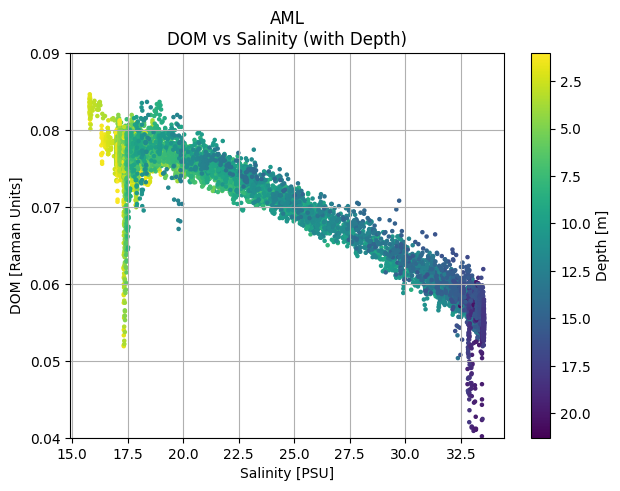

In [345]:
fig, ax = plt.subplots(figsize=(7, 5))

scatter = ax.scatter(
    aml2['Salinity'], 
    aml2['DOM'], 
    c=aml2['Depth'], 
    cmap='viridis_r',
    s=5)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Depth [m]')
cbar.ax.invert_yaxis()  # Invert y-axis of the color bar if needed

# Set labels and title for the subplot
ax.set_xlabel("Salinity [PSU]")
ax.set_ylabel("DOM [Raman Units]")
ax.set_title("AML\nDOM vs Salinity (with Depth)")
ax.set_ylim(0.04, 0.09)
ax.grid()

# Show the plot
plt.show()

In [337]:
rbr2.columns

Index(['Timestamp', 'Station', 'Latitude', 'Longitude', '    depth(m)',
       '    conductivity(mS/cm)', '    temperature(°C)', '    pressure(dbar)',
       '    temperature1(°C)', '    dissolved_o2_concentration(µmol/L)',
       '    chlorophyll-a(ug/l)', '    fdom(ppb)', '    turbidity(FTU)',
       '    voltage(V)', '    voltage1(V)', '    voltage2(V)',
       '    voltage3(V)', '    sea_pressure(dbar)', '    salinity(PSU)',
       '    speed_of_sound(m/s)', '    specific_conductivity(µS/cm)',
       '    dissolved_o2_saturation(%)'],
      dtype='object')

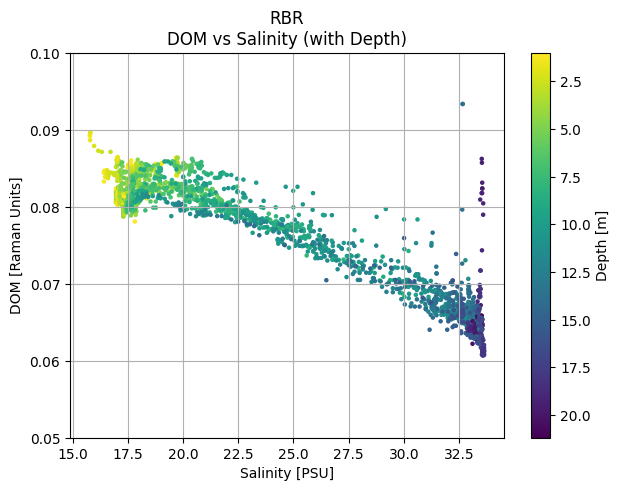

In [343]:
fig, ax = plt.subplots(figsize=(7, 5))

scatter = ax.scatter(
    rbr2['    salinity(PSU)'], 
    rbr2['    fdom(ppb)'], 
    c=rbr2['    depth(m)'], 
    cmap='viridis_r',
    s=5)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Depth [m]')
cbar.ax.invert_yaxis()  # Invert y-axis of the color bar if needed

# Set labels and title for the subplot
ax.set_xlabel("Salinity [PSU]")
ax.set_ylabel("DOM [Raman Units]")
ax.set_title("RBR\nDOM vs Salinity (with Depth)")
ax.set_ylim(0.05, 0.1)
ax.grid()

# Show the plot
plt.show()

In [226]:
lons = data['Longitude']
lats = data['Latitude']
stations = data['Station']

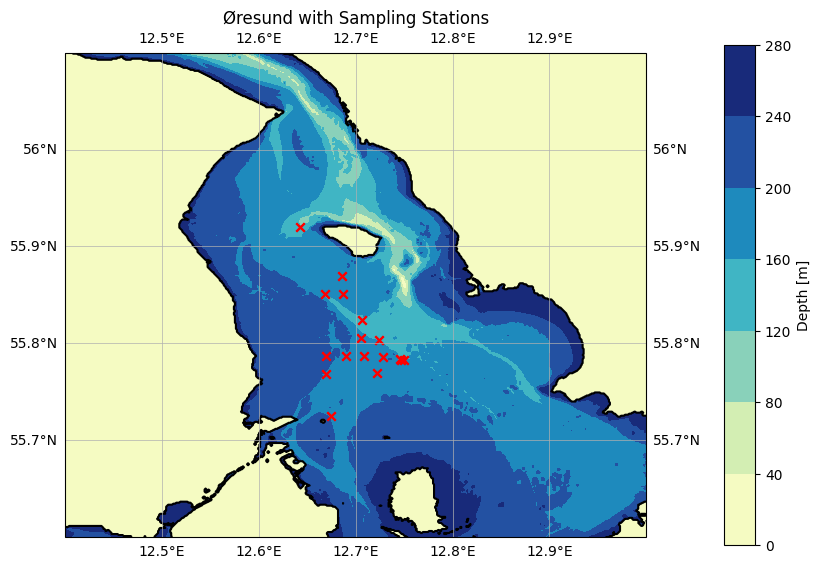

In [422]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import rasterio



# Load bathymetry data from GeoTIFF file
bathymetry_file = 'Raw/bathymetry_2022_5664_ad8f_7055.tif'
with rasterio.open(bathymetry_file) as dataset:
    bathymetry = dataset.read(1)
    transform = dataset.transform
    lons = np.linspace(transform[2], transform[2] + transform[0] * dataset.width, dataset.width)
    lats = np.linspace(transform[5], transform[5] + transform[4] * dataset.height, dataset.height)
    lon, lat = np.meshgrid(lons, lats)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([12.4, 13, 55.6, 56.1], crs=ccrs.PlateCarree())
# ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)


# Plot bathymetry
cs = ax.contourf(lon, lat, bathymetry, cmap='YlGnBu', transform=ccrs.PlateCarree())
contour_levels = [0.5]  # Adjust this threshold as needed
contours = ax.contour(lon, lat, bathymetry, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())

lons = data['Longitude']
lats = data['Latitude']
stations = data['Station']
ax.scatter(lons, lats, color='red', marker='x', transform=ccrs.PlateCarree())

ax.set_xlabel(r'Longitude [$^\circ$]')
ax.set_ylabel(r'Latitude [$^\circ$]')

ax.gridlines(draw_labels=True, linestyle='-', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(cs, ax=ax, orientation='vertical', pad=0.1, aspect=16, shrink=0.65)
cbar.set_label('Depth [m]')
plt.xlabel('Teste')
plt.title('Øresund with Sampling Stations')
plt.show()


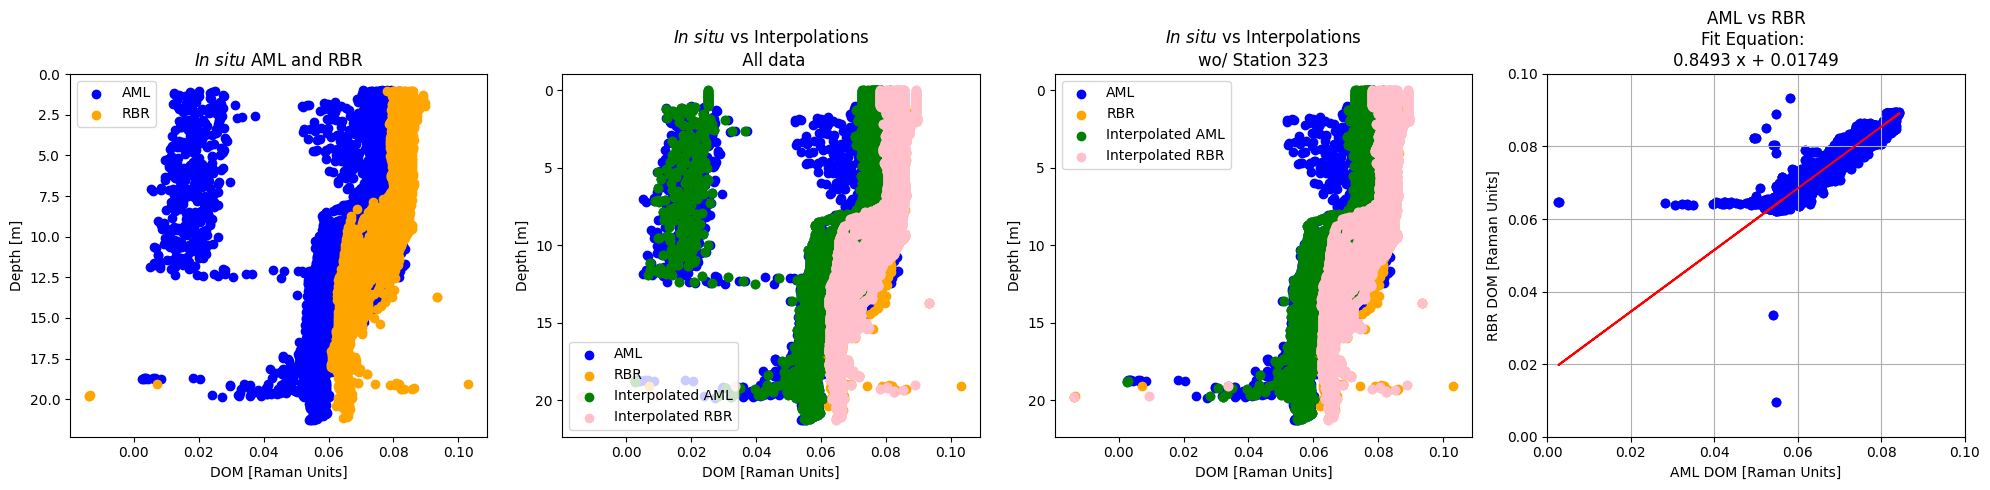

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten()
axs[0].scatter(
    aml['DOM'],
    aml['Depth'],
    color='blue',
    label='AML'
)

axs[0].scatter(
    rbr[(rbr['    fdom(ppb)'] < 20)]['    fdom(ppb)'],
    rbr[(rbr['    fdom(ppb)'] < 20)]['    depth(m)'],
    color='orange',
    label='RBR'
)

axs[0].set_xlabel("DOM [Raman Units]")
axs[0].set_ylabel("Depth [m]")
axs[0].set_title(r'$\it{In\ situ}$'+' AML and RBR')
axs[0].invert_yaxis()
axs[0].legend()


axs[1].scatter(
    aml['DOM'],
    aml['Depth'],
    color='blue',
    label='AML'
)

axs[1].scatter(
    rbr['    fdom(ppb)'],
    rbr['    depth(m)'],
    color='orange',
    label='RBR'
)

axs[1].scatter(
    dom_measure_df['AML DOM'],
    dom_measure_df['Depth'],
    color='green',
    label='Interpolated AML'
)

axs[1].scatter(
    dom_measure_df['RBR DOM'],
    dom_measure_df['Depth'],
    color='pink',
    label='Interpolated RBR'
)

axs[1].set_xlabel("DOM [Raman Units]")
axs[1].set_ylabel("Depth [m]")
axs[1].set_title(r'$\it{In\ situ}$ vs Interpolations'+'\n All data')
axs[1].invert_yaxis()
axs[1].legend()

axs[2].scatter(
    aml2['DOM'],
    aml2['Depth'],
    color='blue',
    label='AML'
)

axs[2].scatter(
    rbr2['    fdom(ppb)'],
    rbr2['    depth(m)'],
    color='orange',
    label='RBR'
)

axs[2].scatter(
    dom_measure_df2['AML DOM'],
    dom_measure_df2['Depth'],
    color='green',
    label='Interpolated AML'
)

axs[2].scatter(
    dom_measure_df2['RBR DOM'],
    dom_measure_df2['Depth'],
    color='pink',
    label='Interpolated RBR'
)

axs[2].set_xlabel("DOM [Raman Units]")
axs[2].set_ylabel("Depth [m]")
axs[2].set_title(r'$\it{In\ situ}$ vs Interpolations' + '\nwo/ Station 323')
axs[2].invert_yaxis()
axs[2].legend()



z = np.polyfit(dom_measure_df2['AML DOM'], dom_measure_df2['RBR DOM'], 1)
p = np.poly1d(z)
axs[3].scatter(
    dom_measure_df2['AML DOM'],
    dom_measure_df2['RBR DOM'],
    color='blue',
)
axs[3].plot(dom_measure_df2['AML DOM'],p(dom_measure_df2['AML DOM']), color='red'), 

axs[3].set_xlabel("AML DOM [Raman Units]")
axs[3].set_ylabel("RBR DOM [Raman Units]")
axs[3].set_title(f"AML vs RBR\nFit Equation:{p}")
axs[3].set_xlim(0, 0.1)
axs[3].set_ylim(0, 0.1)
axs[3].grid()

plt.tight_layout()